In [1]:
#pip install kagglehub


In [2]:
import kagglehub
import pandas as pd
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
csv_file = os.path.join(path, "credit_risk_dataset.csv") 
df = pd.read_csv(csv_file)

# Drop rows with missing values for analysis
df_cleaned = df.dropna()

# Count distinct values in each column
distinct_counts = df_cleaned.nunique()

df_cleaned.info()

# Display distinct counts
print("Distinct values in each column:\n", distinct_counts)

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB
Distinct values in each column:
 per

In [3]:
def filter_missing_values(df):
    # Separate rows with missing values for later use
    df_missing = df[df.isnull().any(axis=1)]

    
    # Check if the file already exists before saving missing values
    file_path = "filtered_missing_values.csv"
    if not os.path.exists(file_path):
        df_missing.to_csv(file_path, index=False)
        print(f"Missing values saved to {file_path}")
    else:
        print(f"{file_path} already exists, skipping save.")
    return df_missing

In [19]:
# Apply age grouping
df_cleaned["Age Group"] = pd.cut(df_cleaned["person_age"], bins=[0, 35, 50, float("inf")], labels=["Below 35", "36-50", "50+"])

numeric_columns = ["person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
grouping_columns = ["Age Group"] + [f"{col} Group" for col in numeric_columns]

def numeric_classifier(df, numeric_columns):
    """Classifies numeric columns into groups based on median values and returns updated DataFrame and medians."""
    medians = {}
    
    for col in numeric_columns:
        median_value = df[col].median()
        medians[col] = median_value  # Store median value
        
        # Apply median-based grouping
        if col in ["loan_int_rate", "loan_percent_income"]:
            median_label = f"{median_value:.2f}"  # Show 2 decimal places
        else:
            median_label = f"{median_value:,.0f}"  # No decimals for other values
        
        df[f"{col} Group"] = df[col].apply(
            lambda x: f"Below or Equal to {median_label} (Median)" if x <= median_value else f"Above {median_label} (Median)"
        )
    
    return df, medians
df_cleaned, medians = numeric_classifier(df_cleaned, numeric_columns)



def grouping(df):
    # Count defaults (1) and non-defaults (0) for each grouped parameter
    
    for col in grouping_columns:
        grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)
        grouped_df.columns = ["Non-Default (0)", "Default (1)"]
    
        # Rename index to match column name
        grouped_df.index.name = col.replace("_", " ").title()
    
        # Print formatted table
        print(tabulate(grouped_df, headers="keys", tablefmt="fancy_grid"))
        
grouping(df_cleaned)

C:\Users\thanh\AppData\Local\Temp\ipykernel_13616\2917809618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Age Group"] = pd.cut(df_cleaned["person_age"], bins=[0, 35, 50, float("inf")], labels=["Below 35", "36-50", "50+"])
C:\Users\thanh\AppData\Local\Temp\ipykernel_13616\2917809618.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col} Group"] = df[col].apply(
C:\Users\thanh\AppData\Local\Temp\ipykernel_13616\2917809618.py:32: FutureWarning: The default of observed=False is depre

╒═════════════╤═══════════════════╤═══════════════╕
│ Age Group   │   Non-Default (0) │   Default (1) │
╞═════════════╪═══════════════════╪═══════════════╡
│ Below 35    │             20038 │          5584 │
├─────────────┼───────────────────┼───────────────┤
│ 36-50       │              2209 │           554 │
├─────────────┼───────────────────┼───────────────┤
│ 50+         │               188 │            65 │
╘═════════════╧═══════════════════╧═══════════════╛
╒═══════════════════════════════════╤═══════════════════╤═══════════════╕
│ Person Income Group               │   Non-Default (0) │   Default (1) │
╞═══════════════════════════════════╪═══════════════════╪═══════════════╡
│ Above 55,956 (Median)             │             12434 │          1885 │
├───────────────────────────────────┼───────────────────┼───────────────┤
│ Below or Equal to 55,956 (Median) │             10001 │          4318 │
╘═══════════════════════════════════╧═══════════════════╧═══════════════╛
╒═════════════

In [5]:
# Display median values
print("\nMedian Values for Grouping:")

# Remove underscore in table titles
for col, median_value in medians.items():
    formatted_median = f"{median_value:.2f}" if col in ["loan_int_rate", "loan_percent_income"] else f"{median_value:,.0f}"
    print(f"{col.replace('_', ' ').title()}: {formatted_median}")


Median Values for Grouping:
Person Income: 55,956
Person Emp Length: 4
Loan Amnt: 8,000
Loan Int Rate: 10.99
Loan Percent Income: 0.15
Cb Person Cred Hist Length: 4


C:\Users\thanh\AppData\Local\Temp\ipykernel_13616\2521440027.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)


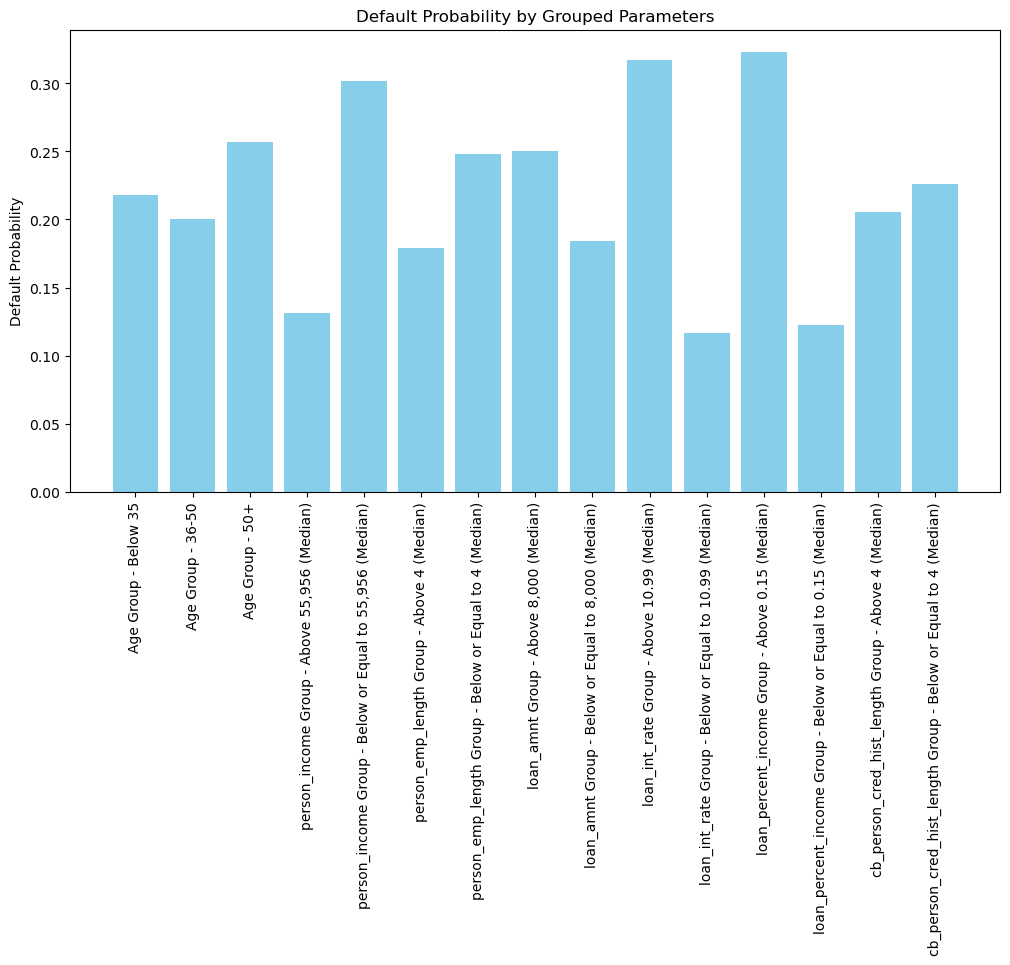

C:\Users\thanh\AppData\Local\Temp\ipykernel_13616\202399053.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)


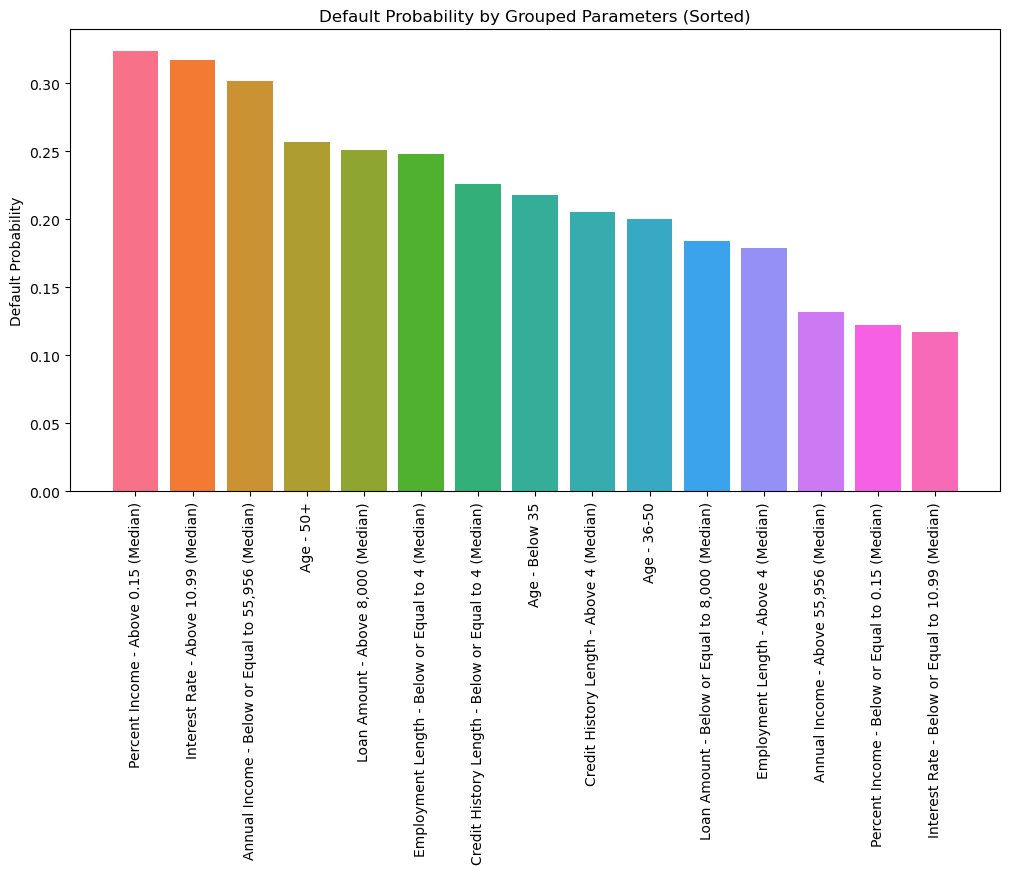

In [27]:
def plot_sorted_default_probabilities(df, grouping_columns, label_mapping):
    """Plots a sorted bar chart with distinct colors for each grouped parameter."""
    probabilities = {}

    # Compute default probabilities
    for col in grouping_columns:
        grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)
        grouped_df.columns = ["Non-Default (0)", "Default (1)"]
        grouped_df["Default Probability"] = grouped_df["Default (1)"] / (grouped_df["Non-Default (0)"] + grouped_df["Default (1)"])

        for category, probability in grouped_df["Default Probability"].items():
            label = f"{label_mapping.get(col, col)} - {category}"
            probabilities[label] = probability

    # Sort probabilities (descending order)
    sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))

    # Generate distinct colors
    colors = sns.color_palette("husl", len(sorted_probs))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_probs.keys(), sorted_probs.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("Default Probability")
    plt.title("Default Probability by Grouped Parameters")
    plt.show()

# Define custom labels for parameters
label_mapping = {
    "Age Group": "Age",
    "person_income Group": "Annual Income",
    "person_emp_length Group": "Employment Length",
    "loan_amnt Group": "Loan Amount",
    "loan_int_rate Group": "Loan Interest Rate",
    "loan_percent_income Group": "Loan over Income",
    "cb_person_cred_hist_length Group": "Credit History Length"
}

# Call function
plot_sorted_default_probabilities(df_cleaned, grouping_columns, label_mapping)
